# Requirements

In [1]:
import torch
import evaluate
import numpy as np
import pandas as p
import seaborn as sns

from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of Spotify user reviews. The dataset contains two attributes:

+ **review** - A text column containing user feedback, opinions, and experiences with the Spotify application.
+ **sentiment** - A categorical column indicating whether the review has a positive or negative sentiment.

Your task involves training a model to predict the **sentiment** (either "positive" or "negative") based on the content of the **review**.

## The Spotify User Reviews Dataset

Load the dataset using the `datasets` library.

In [2]:
dataset = load_dataset("csv", data_files="data/spotify-user-reviews.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})

In [3]:
df = dataset['train'].to_pandas()
df.head()

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive


In [4]:
encoder = LabelEncoder()
values = encoder.fit_transform(dataset['train']['label'])

In [5]:
dataset['train'] = dataset['train'].remove_columns('label')
dataset['train'] = dataset['train'].add_column('label', values)

In [6]:
dataset = dataset.rename_column("review", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [7]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [8]:
checkpoint = "google-bert/bert-base-uncased"

In [9]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [11]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [13]:
training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    learning_rate=0.001,
)

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Define the training using the `Trainer` class.

In [15]:
metric = evaluate.load("f1")

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [17]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Fine-tune (train) the pre-trained lanugage model.

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.817800,0.692710,0.352392


TrainOutput(global_step=500, training_loss=0.8177714233398438, metrics={'train_runtime': 256.4438, 'train_samples_per_second': 31.196, 'train_steps_per_second': 1.95, 'total_flos': 426086941952640.0, 'train_loss': 0.8177714233398438, 'epoch': 1.0})

In [21]:
trainer.evaluate()

{'eval_loss': 0.6927095651626587,
 'eval_f1': 0.3523915622940013,
 'eval_runtime': 15.0886,
 'eval_samples_per_second': 132.55,
 'eval_steps_per_second': 8.284,
 'epoch': 1.0}

Use the trained model to make predictions for the test set.

In [22]:
predictions = trainer.predict(tokenized_dataset["test"])

In [23]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [24]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       966
           1       0.52      1.00      0.68      1034

    accuracy                           0.52      2000
   macro avg       0.26      0.50      0.34      2000
weighted avg       0.27      0.52      0.35      2000



C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

NameError: name 'plt' is not defined

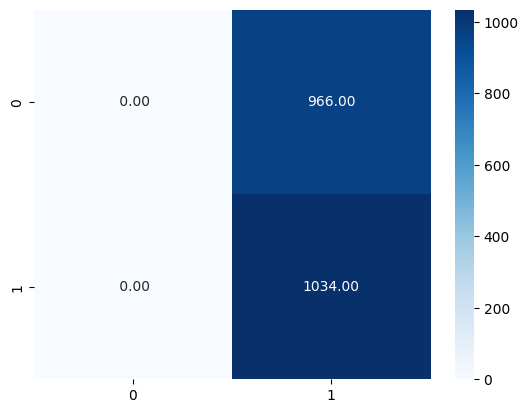

In [25]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a machine learning pipeline to classify Spotify user reviews as positive or negative. Use TF-IDF vectorization to transform the review text into numerical features, and train a logistic regression model on the transformed data. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. To gain insights into the most influential words or phrases associated with positive and negative reviews, analyze the coefficients from the logistic regression model trained on the TF-IDF features. Present the top keywords for each sentiment in a table or a bar chart to provide a clear understanding of the terms driving user feedback.

In [ ]:
dataset = load_dataset("csv", data_files="data/spotify-user-reviews.csv")

In [ ]:
df = dataset['train'].to_pandas()
df.head()

In [ ]:
df['label'].value_counts()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['review'],  df['label'], test_size=0.2)

In [ ]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model.fit(X_train, Y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(Y_test, y_pred))